# Epipolar geometry
A pinhole camera projects a 3D scene down to a 2D plane and thus loses the depth dimension. The solution to this problem is to use two cameras - i.e. stereo vision. If two cameras observe the same scene from offset positions, a point in the imageplane from one of the cameras will lie on a line in the imageplane of the other camera. In this exercise you will be drawing epipolar lines on a set of images to visualize where the two cameras are located in relation to each other in image coordinates.

As always, start by importing necessary libraries.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Exercise 2.1
Use sift to detect and compute features in both the left and right images and optionally visualize the keypoints.

C:\Users\henri\AppData\Local\Temp\ipykernel_13416\10050643.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


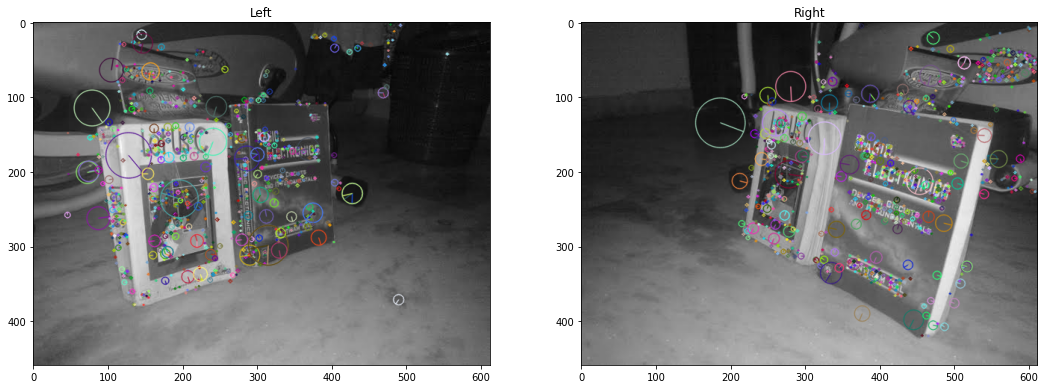

In [2]:
img1 = cv2.imread("img_left.jpg", 0)
img2 = cv2.imread("img_right.jpg", 0)

# Create a sift detector
sift = cv2.xfeatures2d.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img_1 = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img_2 = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(kp_img_1)
ax[0].set_title('Left')
ax[1].imshow(kp_img_2)
ax[1].set_title('Right')
fig.show()

## Exercise 2.2
The next step is to match the features in the two images. We can do that exactly like we did in previous exercises using [`cv2.BFMatcher`](https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html). 

Fill in the missing code below by implementing `cv2.BFMatcher`. Store the matching results in a variable called `matches`. Addtionally use the function [`findFundamentalMat`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gae420abc34eaa03d0c6a67359609d8429) to compute the fundamental matrix.

In [3]:
"""
Implement bf matcher here
"""
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

The above gives us a list of best matches in proritized order. We can then compute the fundamental matrix using a number of the best keypoint matches.

In [4]:
nb_matches = 200

good = []
pts1 = []
pts2 = []

# Using 200 best matches
for m in matches[:nb_matches]:
    good.append(m)
    # Extract points corresponding to matches.
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Implement findFundamentalMat here:
"""
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# We select only inlier points.
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In order to draw the epipolar lines, we can use the following function.

In [5]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

## Exercise 2.3
We can then use the function [`computeCorrespondEpilines`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7), which uses the fundamental matrix and the matching keypoints.

Previously, we selected a number of the best keypoint matches. Try to decrease or increase this number and visuallise the result. What happens with the epipolar lines? Remember you have to compute the fundamental matrix again based on the new number of keypoints.

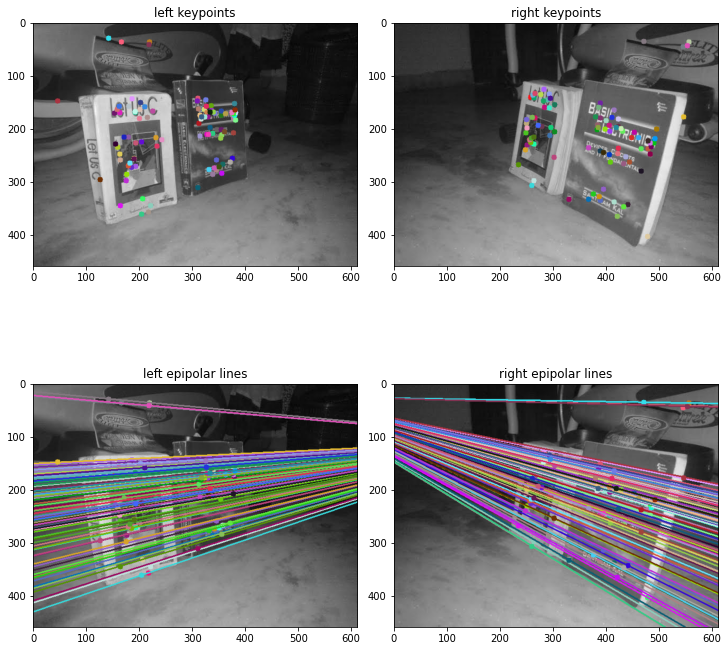

In [6]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

## Optional exercise
The downside of using bf matcher is that it doesn't scale well when the number of keypoints increase. Instead we could opt for using `Fast Library for Approximate Nearest Neighbors (flann)` by sacrificing some accuracy. The exercise is to replace bf match in the previous exercise with a flann based matcher and compare the results.

In [7]:
"""
Implement flann matcher here
"""
#bf = cv2.BFMatcher()
#matches = bf.match(des1, des2)

flann = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = flann.knnMatch(des1, des2, 2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)



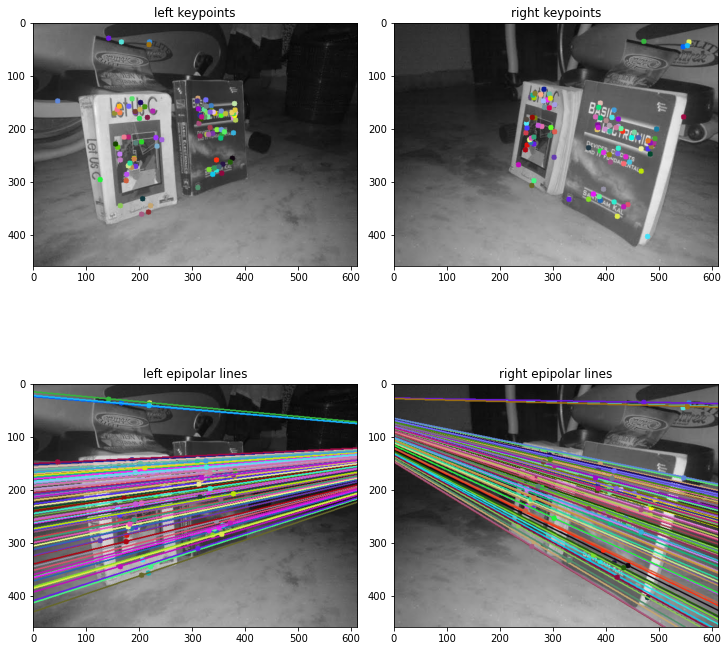

In [8]:
nb_matches = 200

good = []
pts1 = []
pts2 = []

# Using 200 best matches
for m in matches[:nb_matches]:
    good.append(m)
    # Extract points corresponding to matches.
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Implement findFundamentalMat here:
"""
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# We select only inlier points.
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()